In [1]:
# Run python sript if enter_parameters is needed.
# Run ipython or notebook with enter_parameters disabled if cell outputs need to be saved.
run_from_ipython = 'get_ipython' in globals()
# Use ipython display when running notebook. Print directly to console when running sript.
display = display if run_from_ipython else print

In [2]:
import os
import json
import numpy as np
import pandas as pd
import xarray as xr
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt

from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache
from allensdk.brain_observatory.ecephys.visualization import plot_spike_counts, raster_plot

from utils import *
from process import *
from analysis import *
from plots import *

if run_from_ipython:
    %matplotlib inline

with open('config.json') as f:
    config = json.load(f)

In [3]:
# Cache directory path, it determines where downloaded data will be stored
manifest_path = os.path.join(config['cache_dir'], "manifest.json")
cache = EcephysProjectCache.from_warehouse(manifest=manifest_path)

# Whether to manually enter parameters for analysis
enter_parameters = config['enter_parameters']
whether_redo = redo_condition(enter_parameters)

## Get session and probe

In [4]:
session_id = config['analysis_object']['session_id']
ecephys_structure_acronym = config['analysis_object']['ecephys_structure_acronym']
session = cache.get_session_data(session_id)

In [5]:
output_dir = config['output_dir']
session_dir = os.path.join(output_dir, f'session_{session_id:d}')
info_file = os.path.join(output_dir, f'session_{session_id:d}_{ecephys_structure_acronym:s}.json')
with open(info_file) as f:
    info = json.load(f)
print(json.dumps(info, indent=4))

probe_id = info['probe_id']
probe_dir = os.path.join(session_dir, f'probe_{probe_id:d}')
parameters_dict = info['parameters']
fig_disp = figure_display_function(config)

{
    "session_id": 721123822,
    "ecephys_structure_acronym": "VISp",
    "probe_id": 760213145,
    "center_channel_id": 850245983,
    "center_unit_channel_id": 850245985,
    "fs": 1249.99999145772,
    "parameters": {
        "spike_bin_width": 0.03,
        "fr_smooth_sigma": 0.02,
        "fr_normalize_quantile": 0.2,
        "fr_normalization_scale": "range",
        "soft_normalize_cut": 2.069181487856212,
        "stimulus_rise_duration": [
            -0.05,
            0.33
        ],
        "display_PCs": [
            1,
            2
        ],
        "number_top_PCs": 3,
        "select_temporal_frequency_index": [
            0,
            1,
            2,
            3
        ],
        "stimulus_stable_duration": [
            0.3,
            2.001770000000306
        ],
        "number_orientation_clusters": 3,
        "two_step_clustering": true,
        "filter_extend_time": 0.2,
        "filter_freq_band": [
            20.0,
            40.0
        ],
  

## Load selected units in area of interest

In [6]:
units_file = os.path.join(output_dir, f'session_{session_id:d}_{ecephys_structure_acronym:s}_units.csv')
sel_units = pd.read_csv(units_file, index_col='unit_id')
sel_units_id = sel_units.index
print(f'Number of units in {ecephys_structure_acronym:s}: {len(sel_units):d}')

Number of units in VISp: 41


In [7]:
if info['unit_has_ccf']:
    units_dv_coords = sel_units['dorsal_ventral_ccf_coordinate'].copy()
else:
    units_dv_coords = sel_units['dorsal_ventral_ccf_coordinate'].rename('dorsal_ventral_coordinate')

## Load LFP channels

In [8]:
filepath = os.path.join(probe_dir, f'{ecephys_structure_acronym:s}_lfp_channel_groups.nc')
with xr.open_dataset(filepath) as f:
    lfp_array = f.load()
lfp_array = lfp_array.assign_attrs(fs=info['fs']).rename(group_id='channel')
display(lfp_array)

<xarray.Dataset>
Dimensions:  (time: 12263286, channel: 8)
Coordinates:
  * time     (time) float64 0.5328 0.5336 0.5344 ... 9.811e+03 9.811e+03
  * channel  (channel) int32 0 1 2 3 4 5 6 7
Data variables:
    LFP      (channel, time) float32 1.3e-06 1.82e-06 ... -1.55e-05 -8.287e-06
Attributes:
    fs:       1249.99999145772

In [9]:
channel_group_map = pd.read_csv(filepath.replace('.nc', '.csv'), index_col='id')
display(channel_group_map)

,group_id,anterior_posterior_ccf_coordinate,dorsal_ventral_ccf_coordinate,left_right_ccf_coordinate
id,,,,
850245925,7,8545.625000,1435.500000,8019.625000
850245931,7,8545.625000,1435.500000,8019.625000
850245937,7,8545.625000,1435.500000,8019.625000
850245943,6,8575.875000,1347.250000,8024.875000
850245949,6,8575.875000,1347.250000,8024.875000
...,...,...,...,...
850246077,0,8844.181818,583.363636,8054.818182
850246079,0,8844.181818,583.363636,8054.818182
850246081,0,8844.181818,583.363636,8054.818182


## Load PCA results

In [10]:
stimulus_name = 'drifting_gratings'
filepath_prefix = os.path.join(probe_dir, f'{ecephys_structure_acronym:s}_{stimulus_name:s}')

with xr.open_dataset(filepath_prefix + '_pop_vec.nc') as f:
    pop_vec_cond = f.load()
pca_df = pd.read_csv(filepath_prefix + '_units_pca.csv', index_col='unit_id')
orientation_group_df = pd.read_csv(filepath_prefix + '_pca_orient_groups.csv',
                                   index_col='orienation_group_id', converters={'orientation': eval})

## Analyze spike entrainment to LFP

### Preprocess

In [11]:
# Get map from unit to channel group id
channels = session.channels.loc[session.channels['structure_acronym'] == ecephys_structure_acronym]
unit_channel = pd.Series(channel_group_map.loc[sel_units['peak_channel_id'], 'group_id'].values,
                         index=sel_units_id, name='channel_group_id')

In [12]:
# Get stimulus trials
extend_time = 0.2
extend_time, = get_parameters({'filter_extend_time': extend_time}, parameters_dict, enter_parameters)

drifting_gratings_presentations, grating_ids, grating_times, grating_duration = align_gratings(
    session.stimulus_presentations, stimulus_name=stimulus_name)
aligned_lfp = align_trials(lfp_array, grating_ids, grating_times, window=(0. - extend_time, grating_duration + extend_time))
aligned_lfp = aligned_lfp.assign_attrs(extend_time=extend_time)

condition_id, cond_presentation_id = presentation_conditions(
    drifting_gratings_presentations, condtion_types=['orientation', 'temporal_frequency'])

# Get spike times
spike_times = session.presentationwise_spike_times(stimulus_presentation_ids=grating_ids, unit_ids=sel_units_id)

### Beta wave

In [13]:
# Get filtered LFP
freq_band = [20., 40.]
freq_band, = get_parameters({'filter_freq_band': freq_band}, parameters_dict, enter_parameters)
print(f'Filter band: (%.1f, %.1f) Hz' % tuple(freq_band))

lfp_beta = bandpass_lfp(aligned_lfp, freq_band)
spike_phase = get_spike_phase(spike_times, lfp_beta, unit_channel)

Filter band: (20.0, 40.0) Hz


#### Calculate entrainment

In [14]:
temp_freq_idx = list(range(condition_id.temporal_frequency.size))
temp_freq_idx, = get_parameters({'select_temporal_frequency_index': temp_freq_idx}, parameters_dict, False)

sel_tfreq = condition_id.temporal_frequency[temp_freq_idx]
sel_cond = condition_id.sel(temporal_frequency=sel_tfreq)
sel_present = np.concatenate([cond_presentation_id[c] for c in np.ravel(sel_cond)])
plv = phase_locking_value(spike_phase, presentation_ids=sel_present, unbiased=True)

print('Selected conditions:')
print(sel_cond.orientation.to_series().to_string(index=False))
print(sel_cond.temporal_frequency.to_series().to_string(index=False))

Selected conditions:
orientation
  0.0
 45.0
 90.0
135.0
180.0
225.0
270.0
315.0
temporal_frequency
1.0
2.0
4.0
8.0


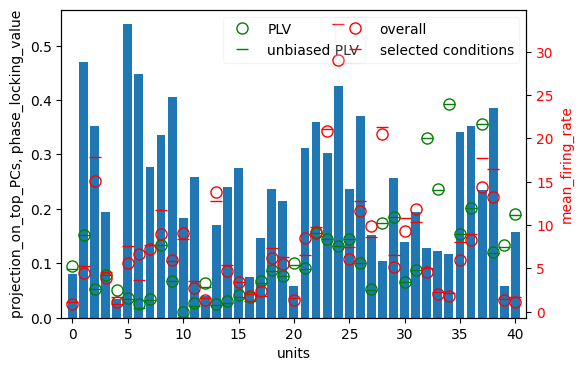

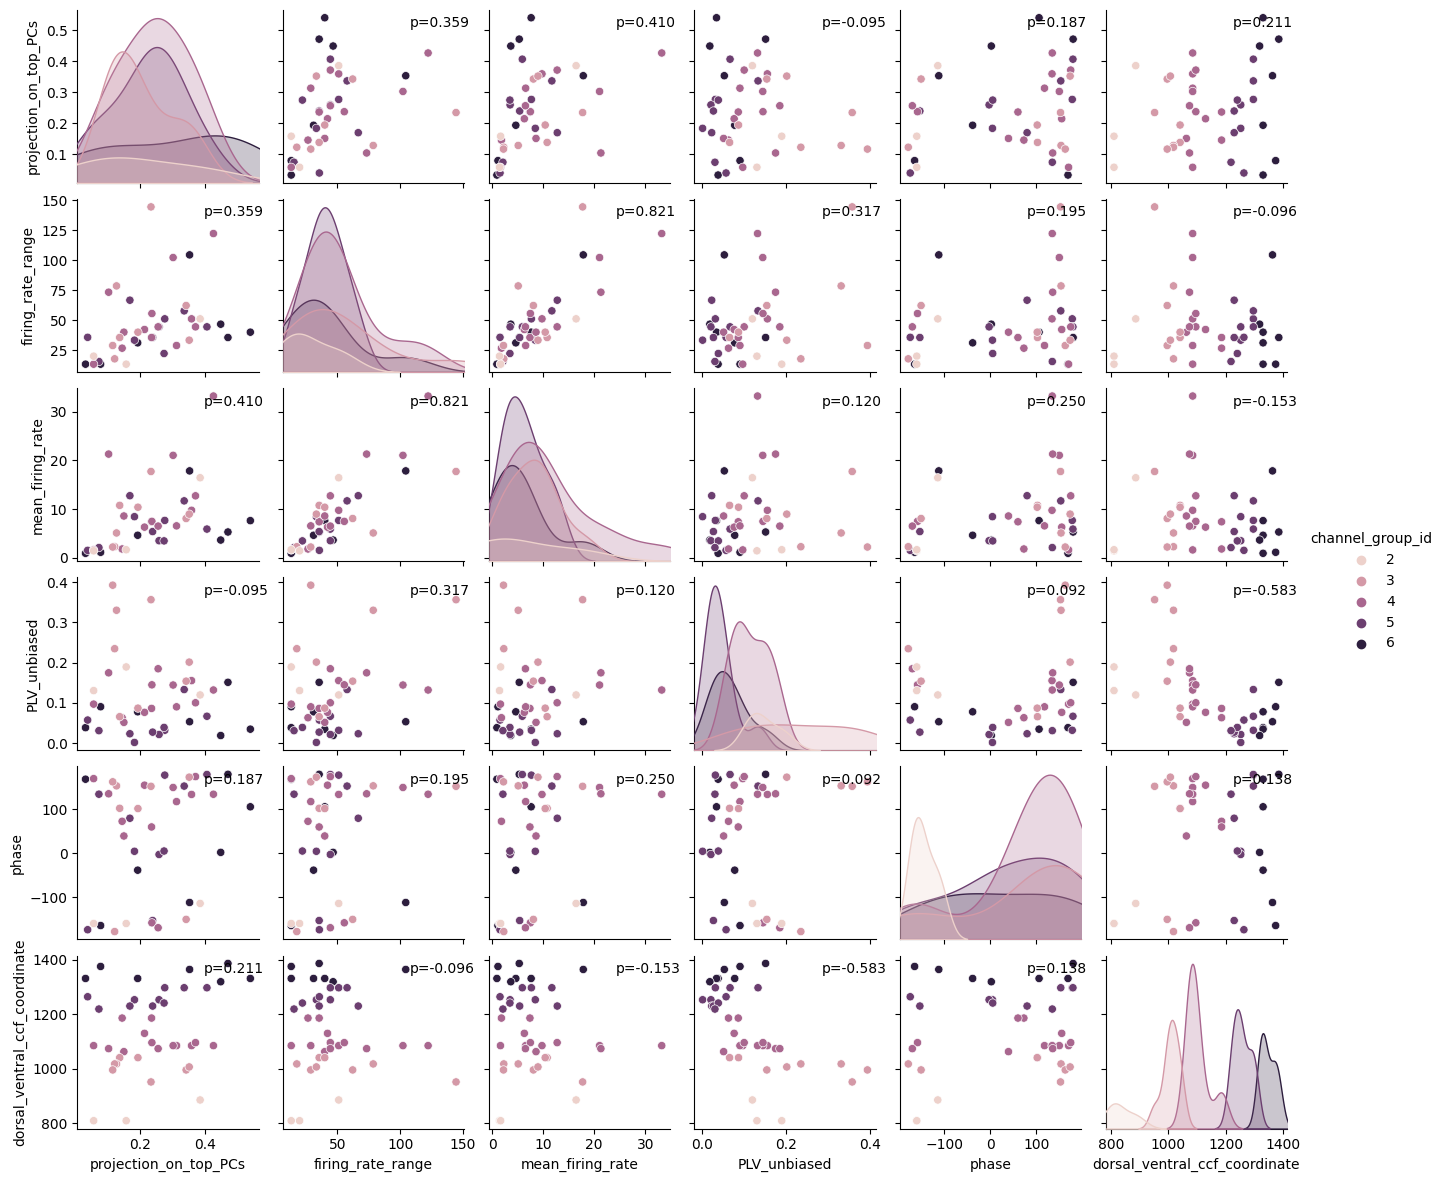

In [15]:
fig1, _ = unit_traits(pca_df, plv)

unit_properties = pd.DataFrame({df.name: df for df in [
    pca_df['projection_on_top_PCs'],
    pca_df['firing_rate_range'],
    plv.mean_firing_rate.to_series(),
    plv.PLV_unbiased.to_series(),
    plv.phase.to_series(),
    units_dv_coords,
    unit_channel
    
]}, index=sel_units_id)

g = sns.pairplot(unit_properties, hue='channel_group_id', diag_kind='kde', height=2., aspect=1.1)
g.map_offdiag(corr_in_plot)
aling_axes_limits(g.axes)
fig2 = g.figure

fig_disp({'unit_traits': fig1, 'units_pair_plot': fig2})

#### Select orientation groups

,orientation,PC_0_component,PC_1_component,PC_2_component,distance
orienation_group_id,,,,,
0,"[0.0, 135.0, 180.0, 315.0]",0.122950,0.048376,-0.164546,0.211027
1,"[45.0, 225.0]",0.166088,-0.207752,0.112388,0.288751
2,"[90.0, 270.0]",-0.017725,0.002157,0.208047,0.208812


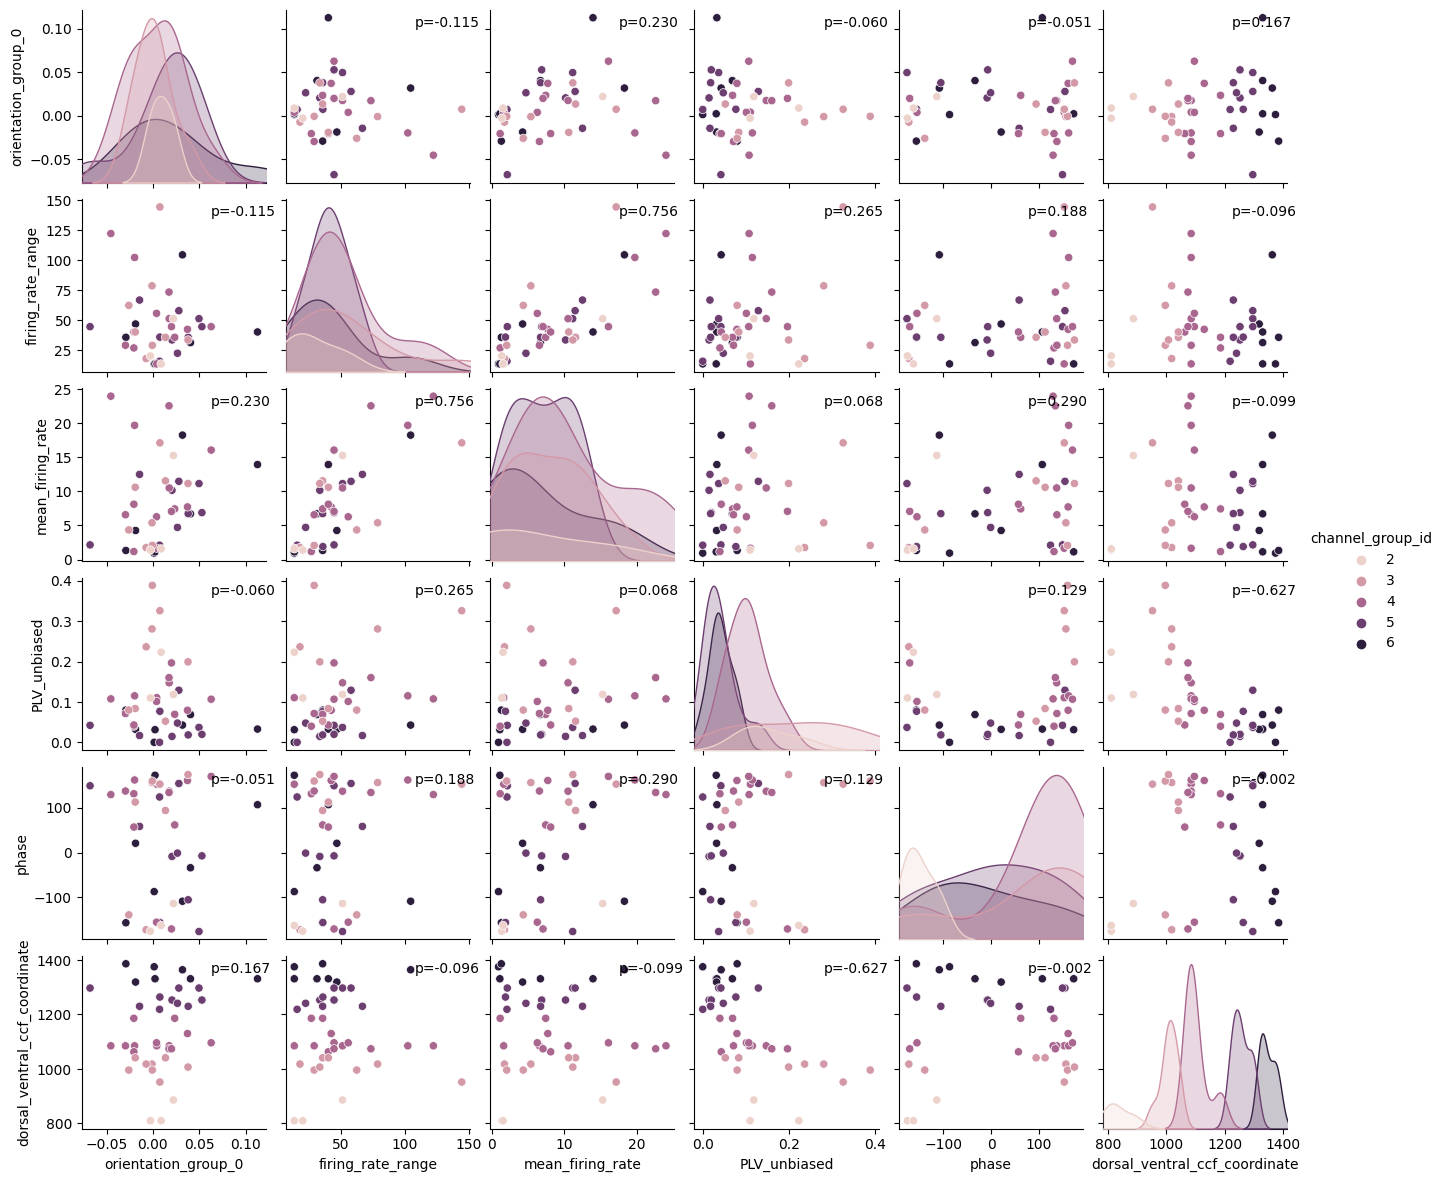

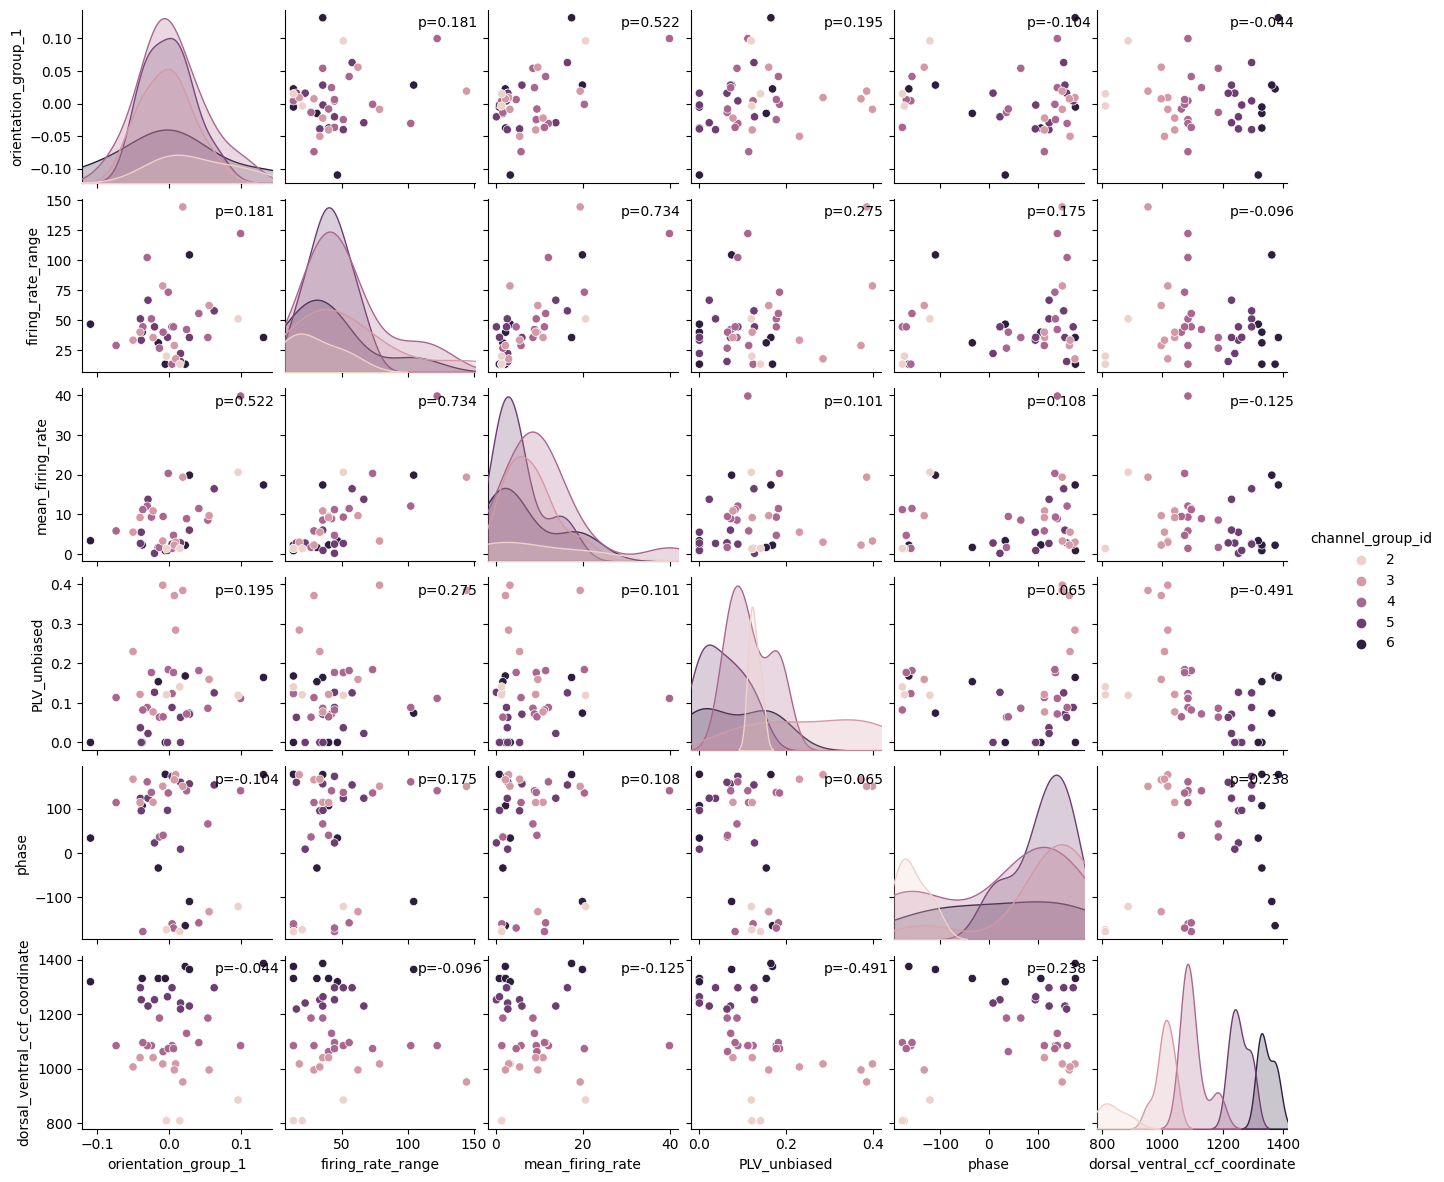

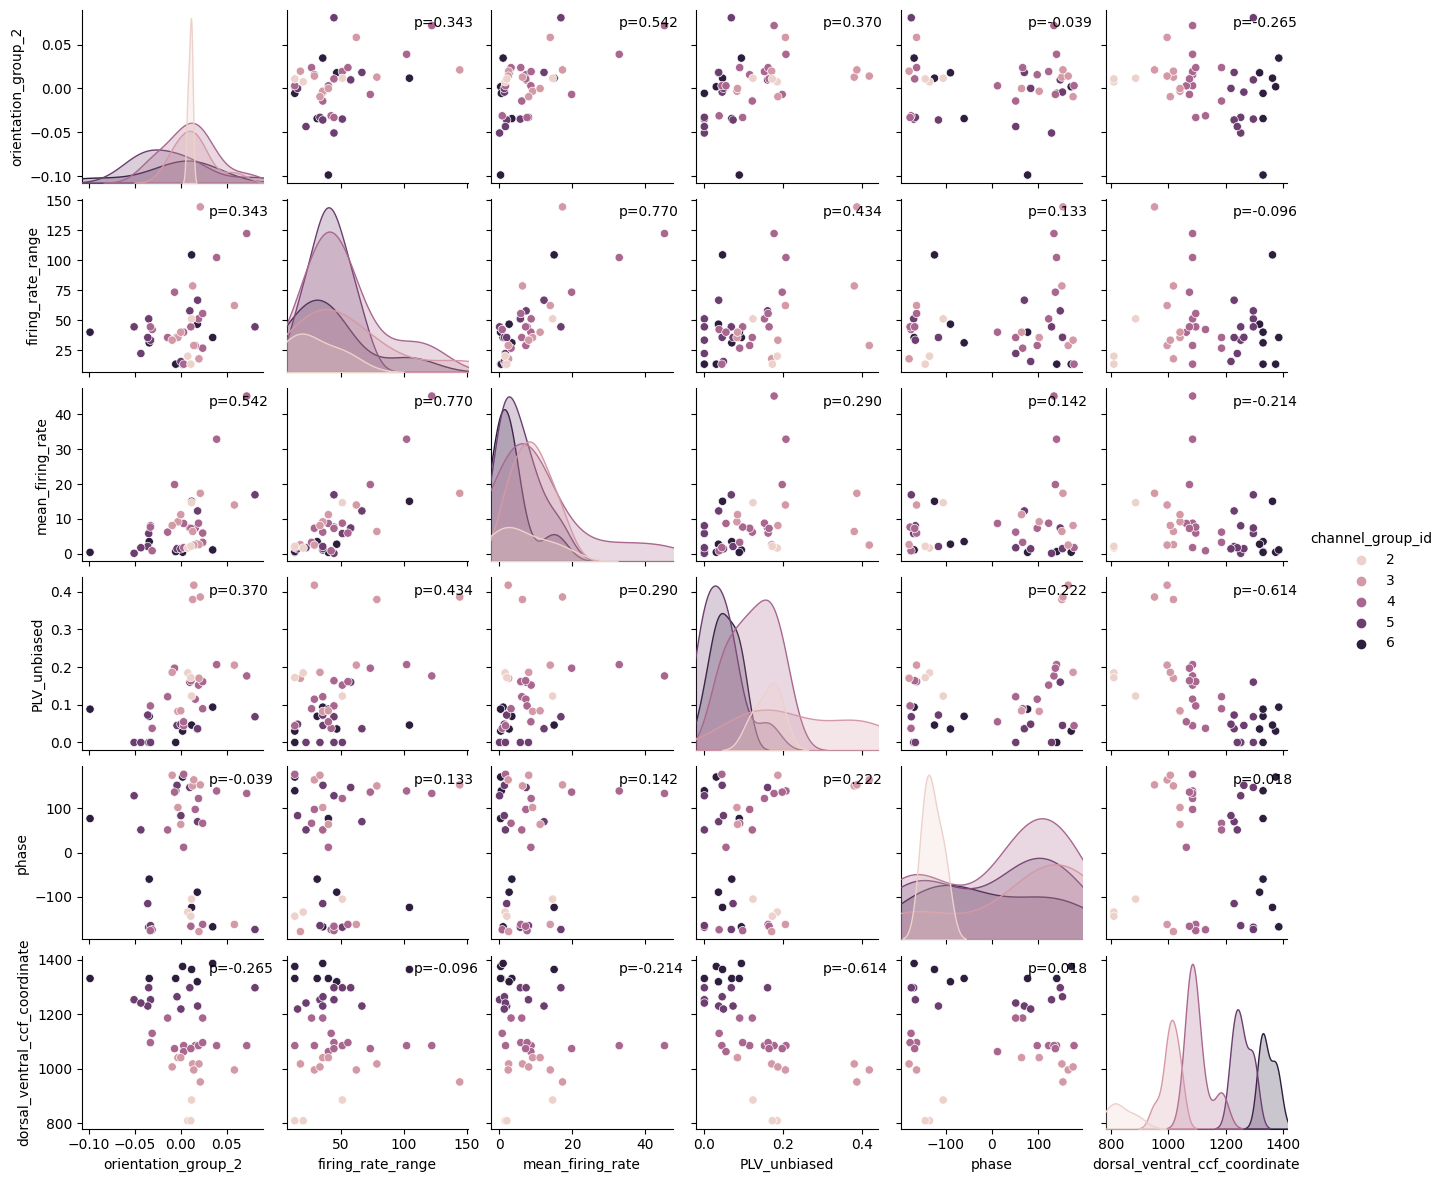

In [16]:
display(orientation_group_df)

for grp, orient_grp in orientation_group_df.iterrows():
    sel_cond = condition_id.sel(temporal_frequency=sel_tfreq, orientation=orient_grp['orientation'])
    sel_present = np.concatenate([cond_presentation_id[c] for c in np.ravel(sel_cond)])
    plv_orient = phase_locking_value(spike_phase, presentation_ids=sel_present, unbiased=True)

    unit_properties = pd.DataFrame({df.name: df for df in [
        pca_df[f'orientation_group_{grp:d}'],
        pca_df['firing_rate_range'],
        plv_orient.mean_firing_rate.to_series(),
        plv_orient.PLV_unbiased.to_series(),
        plv_orient.phase.to_series(),
        units_dv_coords,
        unit_channel
    ]}, index=sel_units_id)

    g = sns.pairplot(unit_properties, hue='channel_group_id', diag_kind='kde', height=2., aspect=1.1)
    g.map_offdiag(corr_in_plot)
    aling_axes_limits(g.axes)
    fig_disp({f'units_pair_plot_orientation_group_{grp:d}': g.figure})

### Population activity vs. beta power

In [17]:
n_orient = pop_vec_cond.orientation.size
n_tfreq = pop_vec_cond.temporal_frequency.size
cmap1 = plt.cm.get_cmap('hsv')(np.arange(n_orient) / n_orient)[:, :3]
cmap2 = plt.cm.get_cmap('jet')(np.arange(n_tfreq) / n_tfreq)[:, :3]

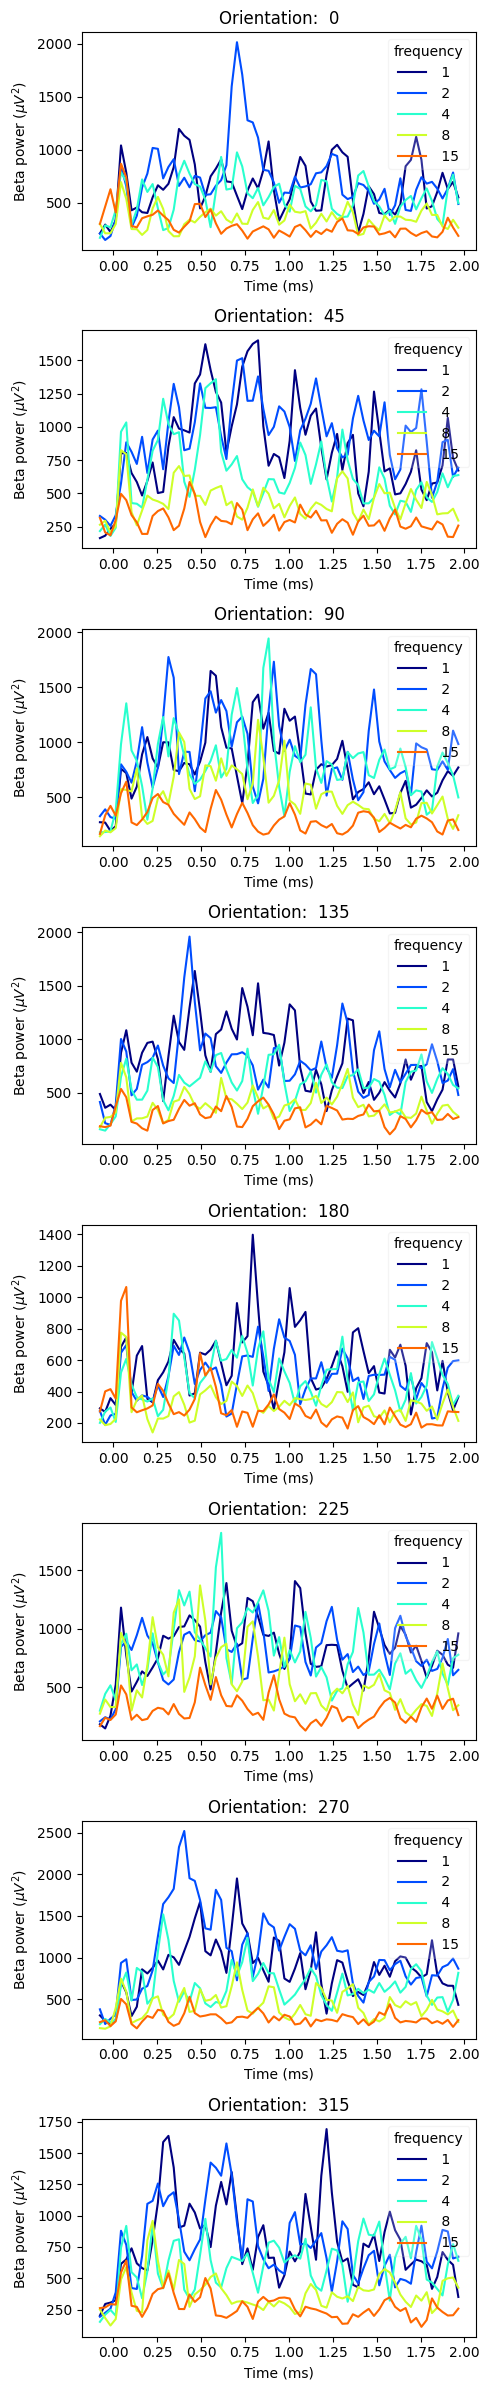

In [18]:
redo = True
while redo:
    whole_duration = (-0.1, grating_duration)
    whole_duration, = get_parameters({'stimulus_whole_duration': whole_duration}, parameters_dict, enter_parameters)

    pop_vec_cond_pc = pop_vec_cond.pop_vec.sel(time_relative_to_stimulus_onset=slice(*whole_duration))
    t = pop_vec_cond_pc.time_relative_to_stimulus_onset.values

    # calculate beta power from amplitude (convert to uV)
    beta_power = (lfp_beta.amplitude * 1e6) ** 2 / 2
    # average over time bins
    beta_power = beta_power.groupby_bins('time_from_presentation_onset', t).mean(dim='time_from_presentation_onset')
    # average over trials
    beta_power = [beta_power.sel(presentation_id=i).mean(dim='presentation_id') for i in cond_presentation_id.values()]
    # collect different conditions
    beta_power = xr.concat(beta_power, dim=pd.Index(cond_presentation_id, name='condition_id'))
    beta_power = beta_power.sel(condition_id=condition_id)
    # average over channels weigthed by number of units near each channel or use the channel with most units
    # beta_power = beta_power.sel(channel=unit_channel.values).mean(dim='channel')
    beta_power = beta_power.sel(channel=unit_channel.mode().values[0])

    _, axs = plt.subplots(n_orient, 1, figsize=(5, 3 * n_orient))
    axs = axs.ravel()
    t_mid = (t[:-1] + t[1:]) / 2
    for i, orient in enumerate(pop_vec_cond.orientation.values):
        ax = axs[i]
        for j, tfreq in enumerate(pop_vec_cond.temporal_frequency):
            ax.plot(t_mid, beta_power.sel(orientation=orient, temporal_frequency=tfreq),
                    color=cmap2[j], label=f'{tfreq: .0f}')
        ax.set_xlabel('Time (ms)')
        ax.set_ylabel(r'Beta power ($\mu V^2$)')
        ax.legend(loc='upper right', title='frequency', framealpha=0.2)
        ax.set_title(f'Orientation: {orient: .0f}')
    plt.tight_layout()
    fig_disp(f'power_evolve_band_{freq_band[0]:g}-{freq_band[1]:g}')

    redo = whether_redo()

Time interval: (-90.0, 1980.0) ms


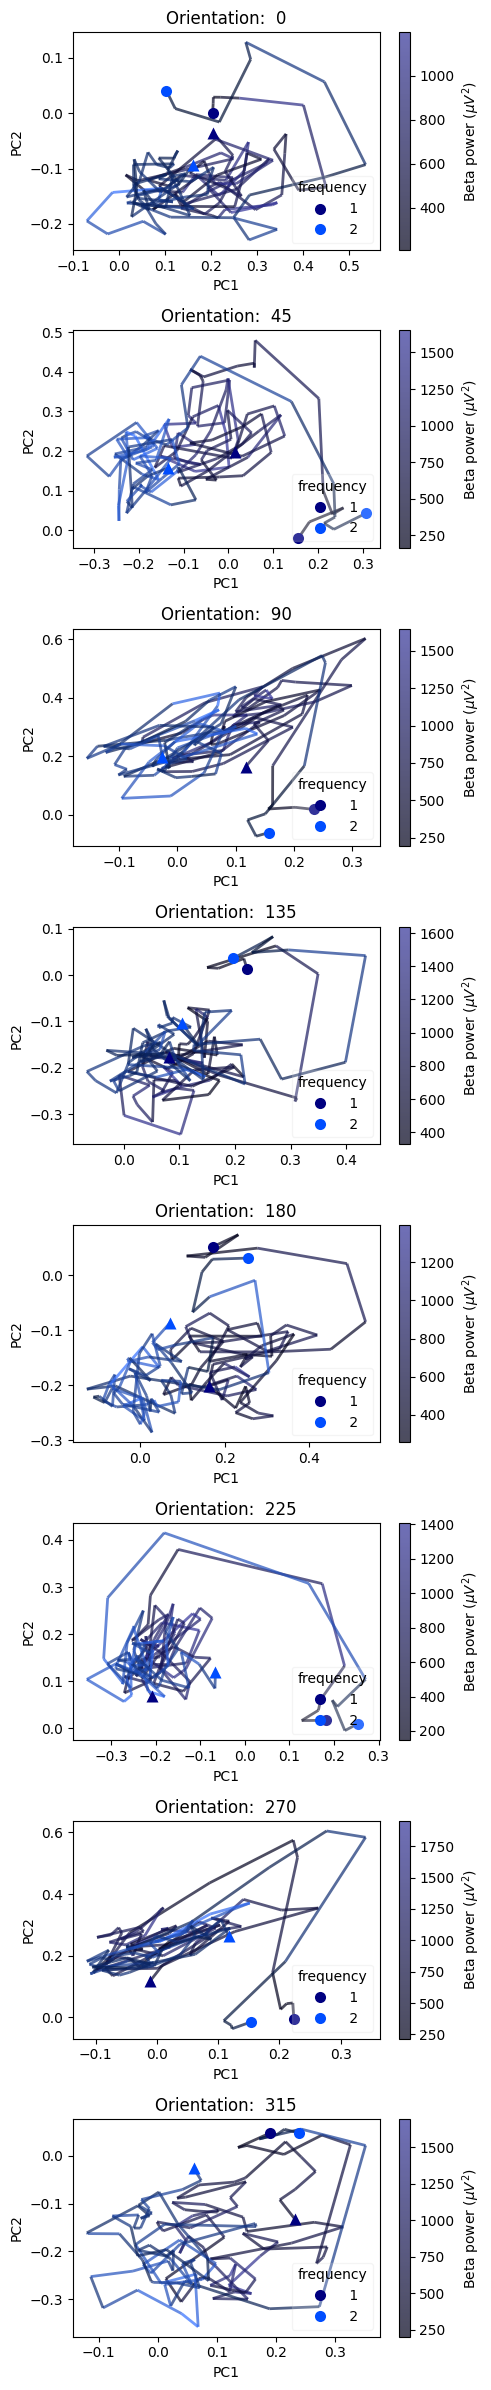

In [19]:
redo = True
while redo:
    temp_freq_idx = list(range(condition_id.temporal_frequency.size))
    PC_disp = [0, 1]
    temp_freq_idx, PC_disp = get_parameters({
        'display_temporal_frequency_index': temp_freq_idx,
        'display_PCs': PC_disp
    }, parameters_dict, enter_parameters)
    sel_tfreq = condition_id.temporal_frequency[temp_freq_idx]

    _, axs = plt.subplots(n_orient, 1, figsize=(5, 3 * n_orient))
    axs = axs.ravel()
    for i, orient in enumerate(pop_vec_cond.orientation):
        ax = axs[i]
        for j, (tfreq_idx, tfreq) in enumerate(zip(temp_freq_idx, sel_tfreq.values)):
            clr = cmap2[tfreq_idx]
            lighten_cmap = get_lighten_cmap(clr, light_scale=0.2, dark_scale=0.8, revert=True)
            pop_vec_tfreq = pop_vec_cond_pc.sel(PC=PC_disp, orientation=orient, temporal_frequency=tfreq)
            beta_power_cond = beta_power.sel(orientation=orient, temporal_frequency=tfreq)
            line = plot_multicolor_line(*pop_vec_tfreq, c=beta_power_cond, ax=ax, cmap=lighten_cmap, linewidth=2, alpha=0.7)
            ax.plot(*pop_vec_tfreq[:, 0], linestyle='none', marker='o',
                    markersize=8, markeredgecolor='none', markerfacecolor=clr, label=f'{tfreq: .0f}')
            ax.plot(*pop_vec_tfreq[:, -1], linestyle='none', marker='^',
                    markersize=8, markeredgecolor='none', markerfacecolor=clr)
            if not j:
                plt.colorbar(mappable=line, ax=ax, label=r'Beta power ($\mu V^2$)')
        ax.set_xlabel(f'PC{PC_disp[0]:d}')
        ax.set_ylabel(f'PC{PC_disp[1]:d}')
        ax.legend(loc='lower right', title='frequency', framealpha=0.2)
        ax.set_title(f'Orientation: {orient: .0f}')
    plt.tight_layout()

    print('Time interval: (%.1f, %.1f) ms' % tuple(1000 * t[[0, -1]]))
    fig_disp(f'power_PC_band_{freq_band[0]:g}-{freq_band[1]:g}')

    redo = whether_redo()

### Gamma wave

In [20]:
# # Get filtered LFP
# freq_band = [40., 75.]
# freq_band, = get_parameters({'filter_freq_band2': freq_band}, parameters_dict, enter_parameters)
# print(f'Filter band: (%.1f, %.1f) Hz' % tuple(freq_band))

# duration = [0., 1.]
# duration, = get_parameters({'duration_freq_band2': duration}, parameters_dict, enter_parameters)
# lfp_gamma = bandpass_lfp(aligned_lfp.sel(time_from_presentation_onset=slice(duration[0] - extend_time, duration[1] + extend_time)),
#                          freq_band, extend_time=extend_time)
# spike_phase = get_spike_phase(spike_times, lfp_gamma, unit_channel)
# print(f'Duration: (%.3f, %.3f) sec' % tuple(duration))

#### Calculate entrainment

In [21]:
# temp_freq_idx = slice(4)
# # temp_freq_idx = eval(input('Selected indices of temporal frequencies: '))
# sel_tfreq = condition_id.temporal_frequency[temp_freq_idx]
# sel_cond = condition_id.sel(temporal_frequency=sel_tfreq)
# sel_present = np.concatenate([cond_presentation_id[c] for c in np.ravel(sel_cond)])
# plv_gamma = phase_locking_value(spike_phase, presentation_ids=sel_present, unbiased=True)

# print('Selected conditions:')
# print(sel_cond.orientation.to_series().to_string(index=False))
# print(sel_cond.temporal_frequency.to_series().to_string(index=False))

In [22]:
# fig1, _ = unit_traits(pca_df, plv_gamma)

# unit_properties = pd.DataFrame({df.name: df for df in [
#     pca_df['projection_on_top_PCs'],
#     pca_df['firing_rate_range'],
#     plv_gamma.mean_firing_rate.to_series(),
#     plv_gamma.PLV_unbiased.to_series(),
#     units_dv_coords,
#     unit_channel
# ]}, index=sel_units_id)

# g = sns.pairplot(unit_properties, hue='channel_group_id', diag_kind='kde', height=2.2, aspect=1.1)
# g.map_offdiag(corr_in_plot)
# aling_axes_limits(g.axes)
# fig2 = g.figure

# fig_disp({'unit_traits2': fig1, 'units_pair_plot2': fig2})

## Save parameters in config

In [23]:
with open(info_file, 'w') as f:
    json.dump(info, f, indent=4)